In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature
from skimage.feature import blob_dog


#Uploading Image


In [ ]:
def calculate_centroid(contour):
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return cX, cY
    else:
        return None

In [ ]:
def group_into_rows(centroids, threshold=50):
    rows = []
    for centroid in centroids:
        added = False
        for row in rows:
            if abs(row[0][1] - centroid[1]) < threshold:
                row.append(centroid)
                added = True
                break
        if not added:
            rows.append([centroid])
    return rows

In [ ]:
def map_contours_to_rows(centroids, contours, rows):
    row_contours = [[] for _ in range(len(rows))]

    for i, row in enumerate(rows):
        for centroid in row:
            # Find the closest contour to the centroid
            closest_contour = min(contours, key=lambda c: np.linalg.norm(np.array(centroid) - np.array(calculate_centroid(c))))
            closest_contour=np.array(closest_contour)
            row_contours[i].append(closest_contour)

    return row_contours[::-1]

In [ ]:
def calculate_average_rgb(image, row_contours):
    average_rgb_values = []
    for row in row_contours:
        row_averages = []
        for contour in row:
            # Create a mask for the current contour
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

            # Extract the RGB values using the mask
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            rgb_pixels = masked_image[mask == 255]

            # Calculate average RGB value
            if len(rgb_pixels) > 0:
                avg_rgb = np.mean(rgb_pixels, axis=0)
                row_averages.append(avg_rgb.tolist())
            else:
                row_averages.append([0, 0, 0])  # If no pixel found, return black
        average_rgb_values.append(row_averages)
    return average_rgb_values

In [ ]:
import json
def generate_json(matrix):
    result = {}
    for i, row in enumerate(matrix, start=1):
        row_key = f"Row{i}"
        row_data = []
        for j, (r, g, b) in enumerate(row, start=1):
            tube_key = f"Tube{j}"
            row_data.append({
                tube_key: {
                    "R": round(r, 2),
                    "G": round(g, 2),
                    "B": round(b, 2)
                }
            })
        result[row_key] = row_data

    return json.dumps(result, indent=2)

In [ ]:
def getRGBVlaues(imagePath):
  image = cv2.imread(imagePath) #return OpenCV matrix the Image color
  if image is not None:
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert to RGB Image
  else:
    print("Error: Could not load Image")
    exit()
  image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # return HSV format of Image
  lowerYellow = np.array([23, 100, 100]) #taking base level of Yellow
  upperYellow = np.array([100, 255, 255])#full yellow limits
  mask = cv2.inRange(image_hsv, lowerYellow, upperYellow)
  yellow_only = cv2.bitwise_and(image, image, mask=mask)#Yello araes in the regions only display
  finalImage = cv2.GaussianBlur(yellow_only, (5, 5), 0)
  gray_image = cv2.cvtColor(finalImage, cv2.COLOR_BGR2GRAY)
  _,binaryImage = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  contours, _ = cv2.findContours(binaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  tubeContours = []
  areas = []
  for contour in contours:
    area = cv2.contourArea(contour)
    if area>200:
      x,y,w,h = cv2.boundingRect(contour)
      aspectRatio = w/h if h!=0 else 0
      if aspectRatio > 0.5 and aspectRatio < 2.0:
        tubeContours.append(contour)
        areas.append(area)

  centroids = []
  for contour in tubeContours:
      centroid = calculate_centroid(contour)
      if centroid:
          centroids.append(centroid)


  filtered_centroids = []
  for i in range(len(centroids)):
      include_centroid = True
      for j in range(i + 1, len(centroids)):
          distance = np.sqrt((centroids[i][0] - centroids[j][0])**2 + (centroids[i][1] - centroids[j][1])**2)
          if distance < 100:
              include_centroid = False  # Mark for removal
              break  # No need to compare further with this centroid
      if include_centroid:
          filtered_centroids.append(centroids[i])
  contour_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  rows = group_into_rows(filtered_centroids)
  for row in rows:
      row.sort(key=lambda c: c[0])
  # Get the contours for each row
  row_contours = map_contours_to_rows(filtered_centroids, tubeContours, rows)
  average_rgb_per_contour = calculate_average_rgb(imageRGB, row_contours)
  return average_rgb_per_contour,row_contours,imageRGB



In [ ]:
imagePath = "/content/Picture1.jpg"
average_rgb_per_contour,row_contours,imageRGB = getRGBVlaues(imagePath)

array([[[255, 251, 230],
        [255, 247, 223],
        [255, 251, 227],
        ...,
        [255, 250, 219],
        [255, 252, 233],
        [255, 253, 241]],

       [[196, 167, 133],
        [166, 136, 100],
        [165, 133,  94],
        ...,
        [169, 136,  93],
        [170, 147, 116],
        [228, 212, 187]],

       [[182, 136,  74],
        [141,  96,  31],
        [138,  91,  23],
        ...,
        [146,  97,  31],
        [141, 104,  52],
        [246, 215, 169]],

       ...,

       [[108,  86,  65],
        [ 45,  24,   3],
        [ 45,  23,   2],
        ...,
        [ 69,  37,  12],
        [ 64,  33,  12],
        [228, 197, 176]],

       [[ 94,  77,  61],
        [ 42,  25,   9],
        [ 39,  22,   6],
        ...,
        [ 68,  41,  20],
        [ 68,  42,  25],
        [217, 194, 176]],

       [[209, 199, 189],
        [196, 186, 176],
        [206, 196, 186],
        ...,
        [217, 205, 193],
        [203, 190, 181],
        [255, 253, 244]]], dtype=uint8)
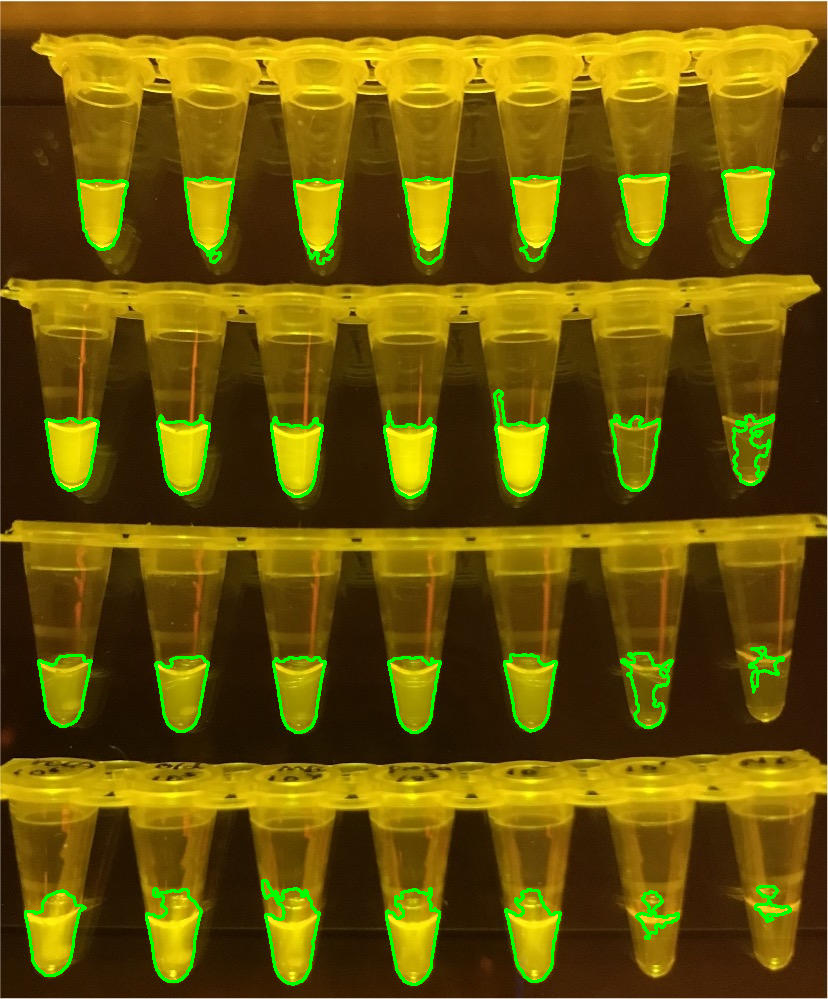

In [ ]:
cv2.drawContours(imageRGB, [np.array(contour) for row in row_contours for contour in row], -1, (0, 255, 0), 2)


In [ ]:
generate_json(average_rgb_per_contour)

'{\n  "Row1": [\n    {\n      "Tube1": {\n        "R": 212.73,\n        "G": 181.27,\n        "B": 11.87\n      }\n    },\n    {\n      "Tube2": {\n        "R": 208.56,\n        "G": 176.28,\n        "B": 11.26\n      }\n    },\n    {\n      "Tube3": {\n        "R": 210.04,\n        "G": 180.51,\n        "B": 10.9\n      }\n    },\n    {\n      "Tube4": {\n        "R": 213.22,\n        "G": 184.01,\n        "B": 10.88\n      }\n    },\n    {\n      "Tube5": {\n        "R": 212.49,\n        "G": 181.77,\n        "B": 11.49\n      }\n    },\n    {\n      "Tube6": {\n        "R": 214.01,\n        "G": 180.77,\n        "B": 13.56\n      }\n    },\n    {\n      "Tube7": {\n        "R": 216.75,\n        "G": 180.17,\n        "B": 13.73\n      }\n    }\n  ],\n  "Row2": [\n    {\n      "Tube1": {\n        "R": 218.94,\n        "G": 202.42,\n        "B": 9.99\n      }\n    },\n    {\n      "Tube2": {\n        "R": 212.78,\n        "G": 197.53,\n        "B": 9.49\n      }\n    },\n    {\n      "